In [1]:
import os
import waveformtools
import numpy as np
import matplotlib.pyplot as plt
from waveformReaderCopy1 import waveformReader as wfmReader
from scipy import stats
from scipy.optimize import curve_fit
###########
# clean and buffer raw data
###########
dir_name = 'C:\\Users\Lucas\\My Drive\\Kao-Halpern Lab\\Data\\Na22Data_aug27'
directory = os.fsencode(dir_name)
i = 0
master_wfms = []
for file in os.listdir(directory)[1:]:
    filename = os.fsdecode(file)
    wfms = wfmReader(dir_name + str('\\') + filename, 2)(-1)    
    wfms_filtered = []
    for waveform in wfms:
        badbuffer = 350 # buffers voltage1 to be sensible, value of ~350 maximizes number of events
                        # number of events = first element in shape of wfms_filtered
                        # controls which portion of waveform is deleted, ex: 1023 deletes all but 1 event
                        # I ran an optimization which found that the maximum number of waveforms occurs at ~350
        time, voltage1, voltage2 = waveform[:, badbuffer:] # get time, voltage arrays for both channels from waveform data
        lim = 5
        a = 20
        if np.mean(voltage1[0:lim])<a and np.mean(voltage2[0:lim])<a: # filter waveforms: if the average of the first few points are 
                                                                      # less than "a", the waveform is kept. This prevents waveforms with
                                                                      # spikes at the beginning
            wfms_filtered.append(waveform[:, badbuffer:])
    if i%10 == 0:
        print (np.shape(wfms_filtered), i, filename) # prints progress as loop is running
    i+=1    
    master_wfms.append(wfms_filtered)   
print (np.shape(wfms_filtered), i, filename)

(198, 3, 674) 0 20220716-ketek-ch1_2_coincidence_r5-30.5V-1.dat
(209, 3, 674) 10 20220716-ketek-ch1_2_coincidence_r5-30.5V-19.dat
(202, 3, 674) 20 20220716-ketek-ch1_2_coincidence_r5-30.5V-28.dat
(215, 3, 674) 30 20220716-ketek-ch1_2_coincidence_r5-30.5V-37.dat
(202, 3, 674) 40 20220716-ketek-ch1_2_coincidence_r5-30.5V-46.dat
(210, 3, 674) 50 20220716-ketek-ch1_2_coincidence_r6-30.5V-0.dat
(191, 3, 674) 60 20220716-ketek-ch1_2_coincidence_r6-30.5V-18.dat
(201, 3, 674) 70 20220716-ketek-ch1_2_coincidence_r6-30.5V-27.dat
(215, 3, 674) 80 20220716-ketek-ch1_2_coincidence_r6-30.5V-36.dat
(206, 3, 674) 90 20220716-ketek-ch1_2_coincidence_r6-30.5V-45.dat
(220, 3, 674) 100 20220716-ketek-ch1_2_coincidence_r6-30.5V-54.dat
(191, 3, 674) 110 20220716-ketek-ch1_2_coincidence_r6-30.5V-63.dat
(202, 3, 674) 120 20220716-ketek-ch1_2_coincidence_r6-30.5V-9.dat


In [2]:
###########
# PHS
###########
v1_peak, v2_peak, v1_area, v2_area = [], [], [], []
wfms_dict = {}
j = 0
for single_set_wfms in master_wfms:
    for i, (time, v1, v2) in enumerate(single_set_wfms):
        j += 1
        # get pulse heights by peak and integration
        #v1_peak.append(max(v1))
        #v2_peak.append(max(v2))
        #v1_area.append(waveformtools.integrate(time, v1, zero_level=5))
        #v2_area.append(waveformtools.integrate(time, v2, zero_level=5))
        
        # create dictionary to keep track of energy and wfms
        # 'key' is the start signal energy of channel 1, 'values' is both waveforms
        key = max(v1)#*0.075
        value = [time, v1, v2]
        wfms_dict[key] = value
print ('Total number of events = {:}'.format(int(j)))
l_array = []

def non_decreasing(L):
    '''
    returns true if L is non-decreasing
    '''
    l_array.append(L)
    return all(x<=y for x, y in zip(L, L[1:]))

###########
# PLI calculation
###########
E_start = 511*2/3 # starting point for window of prompt gamma
E_stop  = 450 # ending point for window of prompt gamma
filtered_events_dict_ch1 = {k: v for k, v in wfms_dict.items() if k >= E_start and k <= E_stop} # events where channel 1 read a prompt gamma energy
filtered_events_dict_ch2 = {k: v for k, v in wfms_dict.items() if k >= E_stop} # events where channel 2 read a prompt gamma energy


def leading_edge_threshold_time(data_arr, time_arr, LET_percent, l_interp):
    LET_percent = LET_percent*0.01 # convert percent to fraction (7.5% --> 0.075)
    data_arr = np.asarray(data_arr)
    LET_pulse_value = max(data_arr)*LET_percent # value of pulse at LET
    idx = (np.abs(data_arr - LET_pulse_value)).argmin() # index of value in array closest to LET percent threshold
    idx_val = data_arr[idx] # value in array closest to LET percent threshold
    
    # interpolate to find time value at LET pulse value
    time_subarray = np.array(time_arr[idx-l_interp:idx+l_interp+1]) # data points to be interpolated (time), "+1" centers interp_fp around "idx"
    volt_subarray = np.array(data_arr[idx-l_interp:idx+l_interp+1]) # "x" coordinates for time data
    if not volt_subarray.size: # if array does not exist because l_interp is too big, make it smaller
        l_interp = 1
        time_subarray = np.array(time_arr[idx-l_interp:idx+l_interp+1])
        volt_subarray = np.array(data_arr[idx-l_interp:idx+l_interp+1]) 
    if len(volt_subarray)>1: # some volt subarrays are single-element arrays I think for some reason...
        LET_time_value = np.interp(LET_pulse_value, volt_subarray, time_subarray)
    else:
        LET_time_value = 0 # if all else fails, just set it to 0 so it doesn't throw an error
    return (LET_time_value)

def make_LET_arrays(filtered_events_dict, LET, l_interp):
    '''
    implements "leading_edge_threshold_time" function by looping through events dic
    args:
        - filtered_events_dict: dictionary of filtered events
        - LET: leading edge threshold value (in %)
        - l_interp: length of interpolation line, for example "5" will make 
                    the interpolation occur for 5 points on either side of the chosen point
    returns:
        - LET_arr_ch1,ch2: array of leading edge threshold values
    '''
    LET_arr_ch1 = []
    LET_arr_ch2 = []
    for key, value in filtered_events_dict.items():
        pulse_time, ch1_pulse, ch2_pulse = filtered_events_dict[key]
        LET_val_ch1 = leading_edge_threshold_time(ch1_pulse, pulse_time, LET, l_interp)
        LET_val_ch2 = leading_edge_threshold_time(ch2_pulse, pulse_time, LET, l_interp)
        LET_arr_ch1.append(LET_val_ch1)
        LET_arr_ch2.append(LET_val_ch2)
    return (LET_arr_ch1, LET_arr_ch2)

LET = 7.5
l_interp = 5 
LET_arr_ch1 = []
LET_arr_ch2 = []

LET_arr_ch1, LET_arr_ch2 = make_LET_arrays(filtered_events_dict_ch1, LET, l_interp)
num_events = (len(LET_arr_ch1)+len(LET_arr_ch2))/2

LET_arr_ch1 = np.append(LET_arr_ch1, make_LET_arrays(filtered_events_dict_ch2, LET, l_interp)[0])
LET_arr_ch2 = np.append(LET_arr_ch2, make_LET_arrays(filtered_events_dict_ch2, LET, l_interp)[1])
num_events = (len(LET_arr_ch1)+len(LET_arr_ch2))/2
print ('Filtered number of events = {:}'.format(int(num_events)))

Total number of events = 24622
Filtered number of events = 4575


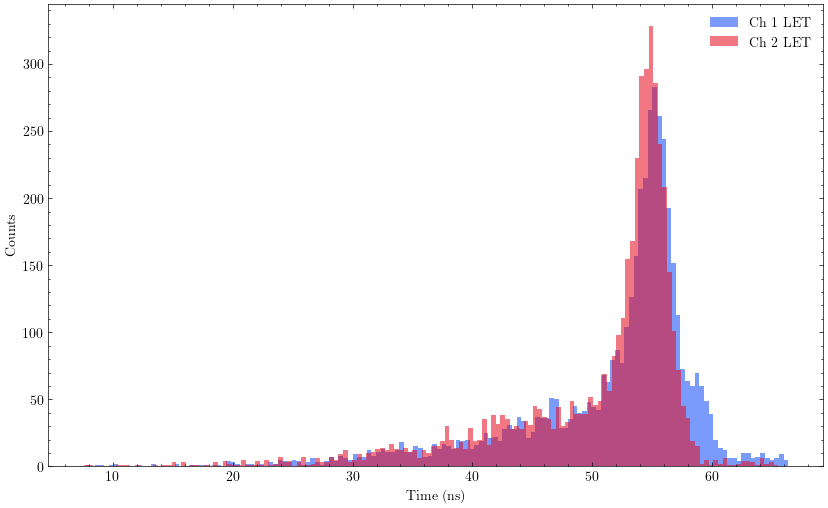

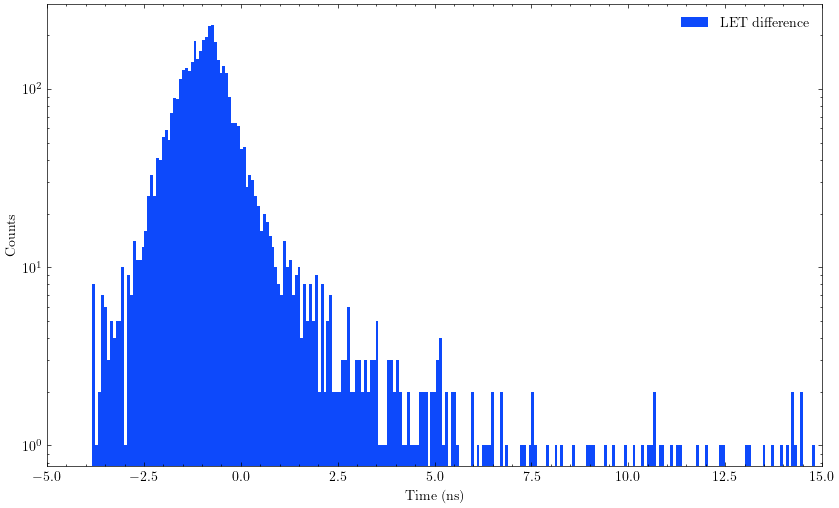

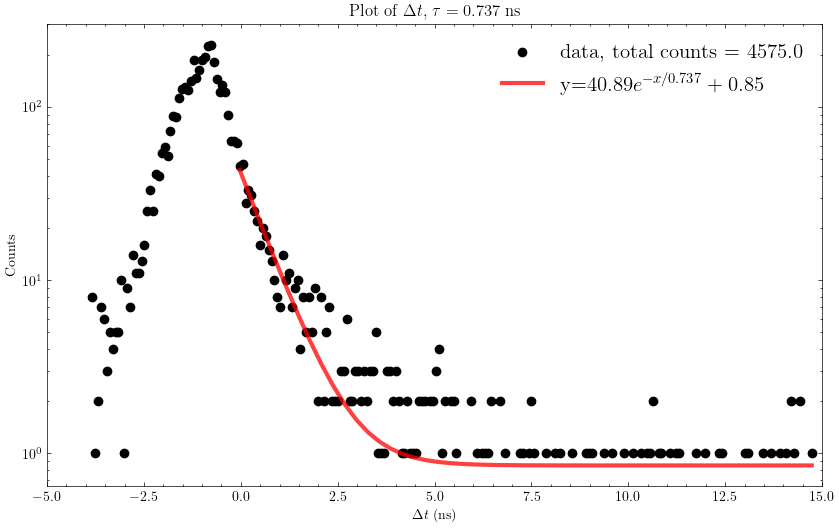

[40.88707365  0.73656006  0.85311626]


In [4]:
# Plotting
def exp_decay(x, a, tau, b):
    return a*np.exp(-x/tau)+b

times = np.array(LET_arr_ch2)-np.array(LET_arr_ch1)
upper_bound = 15
times = [x for x in times if (-4<=x<=upper_bound)] # filter out points way outside of peak
mean, var, skew = stats.skewnorm.fit(times)
x = np.linspace(min(times), max(times), 1000)
p = stats.skewnorm.pdf(x, mean, var, skew)

# shift peak to 0
peak_loc = x[np.where(p==max(p))] #x[index of peak] --> selects x value at peak index
x = x - peak_loc

# params for plots
a = 0.55
b = 150
with plt.style.context(['science', 'high-vis']):
    fig, ax = plt.subplots(figsize=(10,6))#, dpi=300)
    pparam = dict(xlabel='Time (ns)', ylabel='Counts')
    ax.set(**pparam)
    ax.hist(LET_arr_ch1, bins = b, label='Ch 1 LET', alpha=a)
    ax.hist(LET_arr_ch2, bins = b, label='Ch 2 LET', alpha=a)
    plt.legend()
    #plt.savefig('figures/2hists.png')
    plt.show()
    
with plt.style.context(['science', 'high-vis']):
    fig, ax = plt.subplots(figsize=(10,6))#, dpi=300)
    pparam = dict(xlabel='Time (ns)', ylabel='Counts')
    ax.set(**pparam)
    my_bins = 250
    counts, bins, bars = ax.hist(times, my_bins, label='LET difference', density=False)
    #ax.plot(x, p*350, 'k', label='Norm for centering purposes only')
    #title = "Fit results: $\mu$ = %.2f,  $\sigma$ = %.2f" % (mu, std)
    #plt.title(title)
    plt.xlim(-5, upper_bound)
    plt.yscale('log')
    plt.legend()
    #plt.savefig('figures/1hist.png')
    plt.show()
    
# curve fit
p0 = (210, 1.7, 1) # starting search coefs
xdata = bins[0:my_bins]
ydata = counts
# repeat peak finding for new amount of bins/data points
offset = 10 # offset fit from peak, since descending face should be somewhat linear except near peak
peak_index = np.where(ydata==max(ydata))[0][0] #[0][0] selects the index from the tuple
lower_bound = peak_index+offset
popt, pcov = curve_fit(exp_decay, xdata[lower_bound:], ydata[lower_bound:], p0)
x_arr_fit = np.linspace(xdata[lower_bound], max(xdata))

with plt.style.context(['science', 'high-vis']):
    fig, ax = plt.subplots(figsize=(10,6))#, dpi=300)
    pparam = dict(xlabel='$\Delta t$ (ns)', ylabel='Counts')
    ax.set(**pparam)
    ax.scatter(xdata, ydata, label='data, total counts = {:}'.format(num_events), c='k')
    ax.plot(x_arr_fit, exp_decay(x_arr_fit, *popt), 
            label='y=${:.2f} e^{{-x/{:.3f}}}+{:.2f}$'.format(popt[0], popt[1], popt[2]), c='r', lw=3, alpha=0.75)
    #ax.axvline(x=xdata[peak_index], label='lower bound for fit', c='k')
    plt.title(r'Plot of $\Delta t$, $\tau = {:.3f}$ ns'.format(popt[1]))
    plt.yscale('log')
    plt.xlim(-5, upper_bound)
    plt.legend(prop={'size': 15})
    #plt.savefig('figures/PLI_fit.png')
    plt.show()
    
print (popt)